### HVS Orbit Integration in a Dynamic MW+LMC Potential
This notebook performs a backward orbit integration for a single Hypervelocity Star (HVS) using a time-varying gravitational potential that accounts for the motion of both the Milky Way (MW) and the Large Magellanic Cloud (LMC). The primary goal is to compare the trajectory calculated in this more realistic, dynamic potential against the trajectory calculated in a simpler, static potential.

* **Data Loading:**
    * Loads the pre-processed 6D Cartesian phase-space data for the HVS sample.
    * Loads the center-of-mass orbital trajectories for both the MW and LMC, as derived from the Garavito-Camargo et al. (2019) simulations.

* **Potential & Integration:**
    * Imports the custom `MWPotential` class, which has been configured to use the MW and LMC orbital data to create a time-dependent potential.
    * Integrates the orbit of the HVS backward in time for 400 Myr using leapfrog integrator that handles the time-varying acceleration.

* **Comparison & Visualization:**
    * For comparison, it also integrates the same HVS orbit using Gala's built-in static `MilkyWayPotential`.
    * Generates a series of plots to visually compare the results from the two models:
        1.  A 3D plot of the orbital trajectories.
        2.  A set of 2D projections of the orbits (XY, XZ, YZ planes).
        3.  A plot of the total energy over time to check for conservation and compare the behavior of the two potentials.

#### Data loading

In [7]:
# library imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import sys
import os
from tqdm import tqdm

# astropy and gala imports
from astropy import constants as const
import astropy.units as u
import gala.potential as gp
import gala.dynamics as gd
import gala.integrate as gi

# package imports
script_dir = os.getcwd()
project_root = os.path.abspath(os.path.join(script_dir, os.pardir))
src_path = os.path.join(project_root, 'src')
if src_path not in sys.path:
    sys.path.append(src_path)

from hvs_orbital_kinematics.potentials import MWPotential
from hvs_orbital_kinematics.integrators import leapfrog_step_time_varying

# define physical constants
G_KPC_MYR = const.G.to(u.kpc**3 / (u.Msun * u.Myr**2)).value
KM_S_TO_KPC_MYR = (u.km / u.s).to(u.kpc / u.Myr)
GYR_TO_MYR = 1000.0

In [4]:
# load hvs data
hvs_data_path = os.path.join(project_root, 'data', 'processed', '6d_cartesian_data.csv')
cartesian_df = pd.read_csv(hvs_data_path)
print(f"Successfully loaded HVS data from {hvs_data_path}")

# load mw and lmc trajectory dataframes
mw_orbit_path = os.path.join(project_root, 'data', 'raw', 'trajectories', 'GC21M2b1_orbit_mw.txt')
lmc_orbit_path = os.path.join(project_root, 'data', 'raw', 'trajectories', 'GC21M3b1_orbit_lmc.txt')

print("Successfully loaded and processed MW and LMC orbital data.")

Successfully loaded HVS data from /mnt/c/Users/aqin/Desktop/HVS/data/processed/6d_cartesian_data.csv
Successfully loaded and processed MW and LMC orbital data.


#### Comparison against Gala

In [64]:
initial_pos = np.array([0, 10, 0])
initial_vel = np.array([0, 0, 0]) # in km/s

initial_pos_custom = initial_pos
initial_vel_kpcmyr = initial_vel * KM_S_TO_KPC_MYR 
initial_vel_custom = initial_vel_kpcmyr

initial_pos_gala = initial_pos * u.kpc
initial_vel_gala = initial_vel * u.km / u.s

N_STEPS = 800
DT = -0.5
times = np.arange(0, N_STEPS * DT, DT)

In [65]:
dynamic_potential = MWPotential(mw_orbit_path=mw_orbit_path, lmc_orbit_path=lmc_orbit_path)
custom_orbit = np.zeros((N_STEPS, 6))
custom_orbit[0] = np.concatenate([initial_pos_custom, initial_vel_custom])
energies = np.zeros(N_STEPS)

# Integration loop
pos, vel = initial_pos_custom, initial_vel_custom
for i in tqdm(range(N_STEPS), desc="Custom Integration"):
    t = times[i]
    if i > 0:
        pos, vel = leapfrog_step_time_varying(pos, vel, t, DT, dynamic_potential)
    
    custom_orbit[i] = np.concatenate([pos, vel])
    energies[i] = dynamic_potential.get_total_energy(pos, vel, t)

print("Custom integration complete.")

print("\nIntegrating orbit with Gala's static MilkyWayPotential...")
gala_potential = gp.MilkyWayPotential()
initial_phasespace_gala = gd.PhaseSpacePosition(pos=initial_pos_gala, vel=initial_vel_gala)
gala_orbit = gala_potential.integrate_orbit(initial_phasespace_gala, dt=DT*u.Myr, n_steps=N_STEPS-1, Integrator=gi.LeapfrogIntegrator)
print("Gala integration complete.")

/mnt/c/Users/aqin/Desktop/HVS/src/hvs_orbital_kinematics/interpolators.py:22: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(
/mnt/c/Users/aqin/Desktop/HVS/src/hvs_orbital_kinematics/interpolators.py:22: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(


Custom Integration: 100%|██████████| 800/800 [00:00<00:00, 2920.15it/s]


Custom integration complete.

Integrating orbit with Gala's static MilkyWayPotential...
Gala integration complete.


        Use name instead. [gala.dynamics.core]


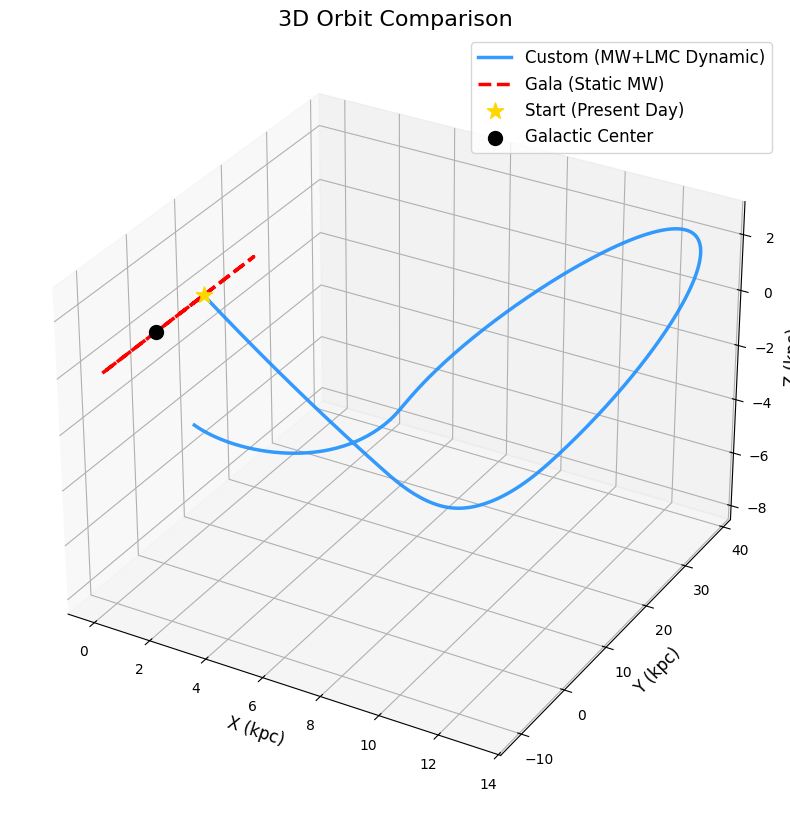

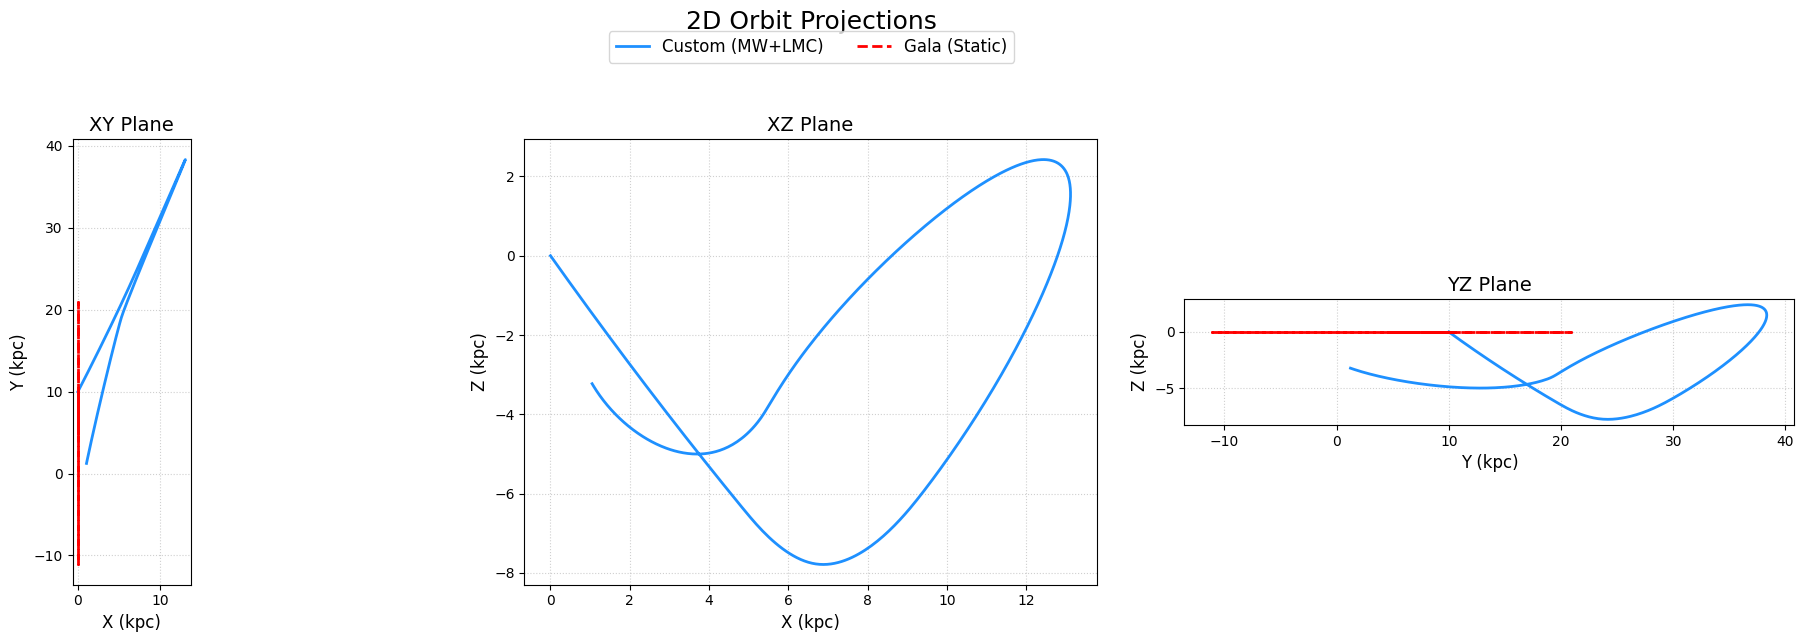

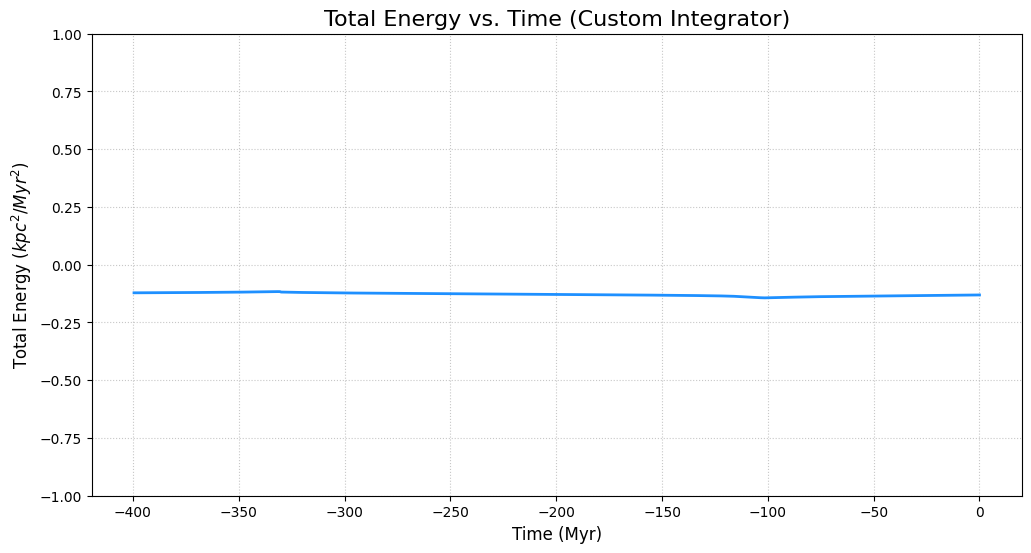

In [66]:
fig_3d = plt.figure(figsize=(12, 10))
ax_3d = fig_3d.add_subplot(111, projection='3d')

# Custom orbit
ax_3d.plot(custom_orbit[:, 0], custom_orbit[:, 1], custom_orbit[:, 2],
           label='Custom (MW+LMC Dynamic)', lw=2.5, color='dodgerblue', alpha=0.9)
# Gala orbit
ax_3d.plot(gala_orbit.x, gala_orbit.y, gala_orbit.z,
           label='Gala (Static MW)', lw=2.5, color='red', linestyle='--')

# Mark start and end points
ax_3d.scatter(initial_pos_custom[0], initial_pos_custom[1], initial_pos_custom[2],
              color='gold', s=150, marker='*', label='Start (Present Day)', zorder=5)
ax_3d.scatter(0, 0, 0, color='black', s=100, marker='o', label='Galactic Center')

ax_3d.set_xlabel("X (kpc)", fontsize=12)
ax_3d.set_ylabel("Y (kpc)", fontsize=12)
ax_3d.set_zlabel("Z (kpc)", fontsize=12)
ax_3d.set_title(f"3D Orbit Comparison", fontsize=16)
ax_3d.legend(fontsize=12)

# 2d plots
fig_2d, axes_2d = plt.subplots(1, 3, figsize=(20, 6.5))
fig_2d.suptitle(f'2D Orbit Projections', fontsize=18)

custom_label = 'Custom (MW+LMC)'
gala_label = 'Gala (Static)'

# XY Plane
axes_2d[0].plot(custom_orbit[:, 0], custom_orbit[:, 1], lw=2, color='dodgerblue', label=custom_label)
axes_2d[0].plot(gala_orbit.x.value, gala_orbit.y.value, lw=2, color='red', linestyle='--', label=gala_label)
axes_2d[0].set_xlabel('X (kpc)', fontsize=12)
axes_2d[0].set_ylabel('Y (kpc)', fontsize=12)
axes_2d[0].set_title('XY Plane', fontsize=14)
axes_2d[0].set_aspect('equal', 'box')
axes_2d[0].grid(True, linestyle=':', alpha=0.6)

# XZ Plane
axes_2d[1].plot(custom_orbit[:, 0], custom_orbit[:, 2], lw=2, color='dodgerblue')
axes_2d[1].plot(gala_orbit.x.value, gala_orbit.z.value, lw=2, color='red', linestyle='--')
axes_2d[1].set_xlabel('X (kpc)', fontsize=12)
axes_2d[1].set_ylabel('Z (kpc)', fontsize=12)
axes_2d[1].set_title('XZ Plane', fontsize=14)
axes_2d[1].set_aspect('equal', 'box')
axes_2d[1].grid(True, linestyle=':', alpha=0.6)

# YZ Plane
axes_2d[2].plot(custom_orbit[:, 1], custom_orbit[:, 2], lw=2, color='dodgerblue')
axes_2d[2].plot(gala_orbit.y.value, gala_orbit.z.value, lw=2, color='red', linestyle='--')
axes_2d[2].set_xlabel('Y (kpc)', fontsize=12)
axes_2d[2].set_ylabel('Z (kpc)', fontsize=12)
axes_2d[2].set_title('YZ Plane', fontsize=14)
axes_2d[2].set_aspect('equal', 'box')
axes_2d[2].grid(True, linestyle=':', alpha=0.6)

handles, labels = axes_2d[0].get_legend_handles_labels()
fig_2d.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 0.96), ncol=2, fontsize=12)
plt.tight_layout(rect=[0, 0, 1, 0.90])
plt.show()


# --- Energy Conservation Plot ---
plt.figure(figsize=(12, 6))
plt.plot(times, energies, lw=2, color='dodgerblue')
plt.title('Total Energy vs. Time (Custom Integrator)', fontsize=16)
plt.xlabel('Time (Myr)', fontsize=12)
plt.ylabel(r'Total Energy ($kpc^2 / Myr^2$)', fontsize=12)
plt.grid(True, linestyle=':', alpha=0.7)
plt.ylim(-1, 1)

ax_energy = plt.gca()
ax_energy.get_yaxis().get_major_formatter().set_useOffset(False)

plt.show()


#### Probability distribution plots